In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from pykrige.ok import OrdinaryKriging

In [2]:
# Import our borehole data
source_boreholes = '../data/GIS/UFS_Boreholes.shp'
# Feed the path to the file to the Geopandas Read File function
df_boreholes = gpd.read_file(source_boreholes)
# Let us display some basic information of the loaded shapefile
df_boreholes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          48 non-null     object  
 1   CollarHeig  41 non-null     float64 
 2   Diameter    41 non-null     float64 
 3   Radius      41 non-null     float64 
 4   Depth       41 non-null     float64 
 5   TopElevati  41 non-null     float64 
 6   BotElevati  41 non-null     float64 
 7   xcoord      48 non-null     float64 
 8   ycoord      48 non-null     float64 
 9   zcoord      48 non-null     float64 
 10  geometry    48 non-null     geometry
dtypes: float64(9), geometry(1), object(1)
memory usage: 4.3+ KB


In [3]:
# Next, let's convert our boreholes to a projected CRS
df_boreholes_Merc = df_boreholes.to_crs(3395)

In [4]:
# Import our elevation data
bfn_elevations = '../data/GIS/BFN_Elevations.shp'
df_bfn_elevations = gpd.read_file(bfn_elevations)
# Interpolation requires our CRS units in meters
df_bfn_elevations = df_bfn_elevations.to_crs(3395)
df_bfn_elevations.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
# Visualize our elevation points
df_bfn_elevations['z'] = df_bfn_elevations.geometry.apply(lambda geom: geom.z if geom.has_z else 0)
df_bfn_elevations.explore(column="z", cmap="rainbow")

In [6]:
# Get the total bounds of the points
min_x, min_y, max_x, max_y = df_bfn_elevations.total_bounds
# Buffer a bit
min_x = int(min_x)
max_x = int(max_x)
min_y = int(min_y)
max_y = int(max_y)
# Calculate spacing for 30 metre intervals
# Using 30 metres because that is the resolution of our data
x_intervals = int((max_x - min_x) / 30)
y_intervals = int((max_y - min_y) / 30)

In [7]:
# Extract the coordinates for our elevation points
coords = np.array([(point.x, point.y, point.z) for point in df_bfn_elevations.geometry])
coords

array([[ 2.91394228e+06, -3.36721632e+06,  1.43500000e+03],
       [ 2.91397320e+06, -3.36721632e+06,  1.43500000e+03],
       [ 2.91400413e+06, -3.36721632e+06,  1.43400000e+03],
       ...,
       [ 2.91613775e+06, -3.36968104e+06,  1.40500000e+03],
       [ 2.91616867e+06, -3.36968104e+06,  1.40500000e+03],
       [ 2.91619959e+06, -3.36968104e+06,  1.40500000e+03]],
      shape=(5254, 3))

In [8]:
# Define the grid extent
gridx = np.linspace(min_x, max_x, x_intervals)
gridy = np.linspace(min_y, max_y, y_intervals)

# Perform Ordinary Kriging
Ordin_Kriging = OrdinaryKriging(x=coords[:, 0], y=coords[:, 1], z=coords[:, 2], variogram_model='linear')
z, ss = Ordin_Kriging.execute('grid', gridx, gridy)

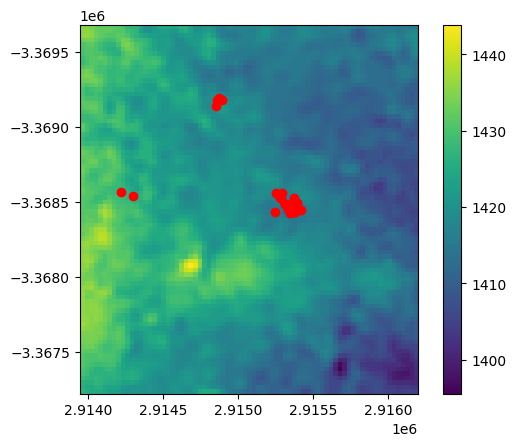

In [9]:
# Plot the krigin results
plt.imshow(z, extent=[min_x, max_x, min_y, max_y])
plt.colorbar()
# Plot the UFS boreholes (not clipped)
bh_coords = np.array([(point.x, point.y) for point in df_boreholes_Merc.geometry])
plt.scatter(bh_coords[:, 0], bh_coords[:, 1], color='r')
plt.gca().invert_yaxis()
# Show the plot
plt.show()